In [7]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
import os
from joblib import Parallel, delayed
import time
from numba import njit
import pickle
from matplotlib import colors

@njit()
def diffusion(size,sigma,mu):
    gamma_m = 6*np.pi*0.3*0.01
    gamma = 6*np.pi*mu*0.005*size
    return ((sigma/(gamma_m+gamma))**2)/2

def Pe(r,vc):
    return [np.sqrt(np.dot(vc,vc))/np.sqrt(np.dot(v-vc,v-vc)) for v in r]

def Sp(r,vc):
    return [np.dot(v,vc)/np.sqrt(np.dot(vc,vc)) for v in r]

def Co(r,vc):
    return [np.dot(v,vc)/np.sqrt(np.dot(vc,vc))/np.sqrt(np.dot(v,v)) for v in r]

@njit()
def plus(n,kplus,dt):
    return kplus*dt

@njit()
def minus(n,kminus,dt):
    return kminus*dt

@njit()
def on(n,kon0,kon1,dt):
    return (kon0+kon1*(n-1))*dt

@njit()
def off(n,koff0,koff1,dt):
    return koff0*dt

@njit() #makes this fast using numba magic!
def Model2ABM(kon,koff,mu,sigma,vc,tend):
    x0 = 0
    y0 = 0
    t0 = 0
    dt = 0.001
    tgrid = np.arange(t0,tend+dt,dt)
    kplus = 0.05
    kminus = 0.1
    kon0 = kon
    kon1 = 0
    koff0 = koff
    koff1 = 0
    m = 2
    #
    # Set up initial condtions, and initialize storage vectors
    #
    x = np.empty(tgrid.size)
    y = np.empty(tgrid.size)
    x[0] = x0
    y[0] = y0
    n = np.empty(tgrid.size)
    n[0] = np.random.randint(low=1,high=(10+1)) #random size between 1 and 10 at t0
    b = np.empty(tgrid.size)
    b[0] = 0
    #
    # time loop
    #
    for i in range(1,tgrid.size):
        #update diffusion
        D = diffusion(n[i-1],sigma,mu)
        #update position
        x[i] = x[i-1] + b[i-1]*vc[0]*dt + np.sqrt(2*D*dt)*np.random.randn()
        y[i] = y[i-1] + b[i-1]*vc[1]*dt + np.sqrt(2*D*dt)*np.random.randn()
        #
        # Calculate reaction probabilities (calls functions for the size dependent reaction rates)
        #
        probs = np.array([plus(n[i-1],kplus,dt),minus(n[i-1],kminus,dt),on(n[i-1],kon0,kon1,dt),off(n[i-1],koff0,koff1,dt)]) #vector of probabilities
        # these reactions are thus indexed by rxn = 0, 1, 2, 3
        #
        #Determine which reaction occurs for this time step
        #
        r = np.random.rand() #draw a random number
        j = 0 #reaction index
        p_sum = 0.0 #running total of probabilities
        while p_sum < r:
            #while the running total is less than the random number
            if j == 4: #if we've gone through all the reactions,
                j = 5  #increase j by 1
                break  #quit the loop
            #add the probabilitiy
            p_sum += probs[j] #add the next reaction's probability
            j+= 1 #increase index by 1
        #THUS, j-1 is the index of the reaction to do
        rxn = j-1
        if rxn == 0:
            #kplus
            n[i] = n[i-1]+1 #increase size by 1
            b[i] = b[i-1] #binding state does not change
        elif rxn == 1:
            #kminus
            if n[i-1] == 1: #if the size decreses by 1, but there is only one monomer, then do nothing
                n[i] = n[i-1]
                b[i] = b[i-1]
            else:
                n[i] = n[i-1]-1 #decrease size by 1
                b[i] = b[i-1] #binding state does not change
        elif rxn == 2:
            #kon
            n[i] = n[i-1] #size does not change
            b[i] = 1 #boolean variable: bound!
        elif rxn == 3:
            #koff
            n[i] = n[i-1] #size does not change
            b[i] = 0 #boolean variable: unbound!
        elif rxn == 4:
            #do nothing
            n[i] = n[i-1]
            b[i] = b[i-1]
        else:
            break
            print('Error in reactions')
    #
    # data storage
    #
    tint = 1000 #delta_t_analysis (1000 * 0.001 s = 1 seconds)
    data = np.empty((len(tgrid[::tint]),4)) #store trajectory in a matrix of size (...x4)
    #... time points, corresponding to t = 0,1,2,3,...,480
    data[:,0] = x[::tint] #x coord in first column
    data[:,1] = y[::tint] #y coord in second column
    data[:,2] = n[::tint] #size in third column
    data[:,3] = b[::tint] #bound/unbound in fourth column

    return data

def velo_x_bound_pdf(x,kon,koff,sigma,mu,k):
    a = kon/(kon+koff)
    b = np.sqrt(4*np.pi*diffusion(k,sigma,mu))
    return (a/b)*np.exp(-((x+0.1)**2)/(4*diffusion(k,sigma,mu)))

def velo_x_unbound_pdf(x,kon,koff,sigma,mu,k):
    a = kon/(kon+koff)
    b = np.sqrt(4*np.pi*diffusion(k,sigma,mu))
    return ((1-a)/b)*np.exp(-(x**2)/(4*diffusion(k,sigma,mu)))

def velo_x_pdf(x,kon,koff,sigma,mu,k):
    return velo_x_bound_pdf(x,kon,koff,sigma,mu,k) + velo_x_unbound_pdf(x,kon,koff,sigma,mu,k)

def velo_y_pdf(x,kon,koff,sigma,mu,k):
    b = np.sqrt(4*np.pi*diffusion(k,sigma,mu))
    return (1/b)*np.exp(-(x**2)/(4*diffusion(k,sigma,mu)))

def velo_y_bound_pdf(x,kon,koff,sigma,mu,k):
    a = kon/(kon+koff)
    b = np.sqrt(4*np.pi*diffusion(k,sigma,mu))
    return (a/b)*np.exp(-(x**2)/(4*diffusion(k,sigma,mu)))

def velo_y_unbound_pdf(x,kon,koff,sigma,mu,k):
    a = kon/(kon+koff)
    b = np.sqrt(4*np.pi*diffusion(k,sigma,mu))
    return ((1-a)/b)*np.exp(-(x**2)/(4*diffusion(k,sigma,mu)))

def plot_setup():
    plt.rcParams['text.usetex'] = False
    plt.rcParams['pdf.fonttype'] = 42
    plt.rcParams['ps.fonttype'] = 42
    plt.rcParams['mathtext.fontset'] = 'cm'
    # plt.rcParams['figure.autolayout'] = 'True'

    sns.set_style('ticks',{'axes.edgecolor': '[0,0,0]',
                           'xtick.direction':'in',
                           'ytick.direction':'in',
                           'ytick.right':'True',
                           'xtick.top':'True',
                           'xtick.color':'k',
                           'ytick.color':'k'
                            })

def mc(i,params):
    rng = np.random.default_rng()
    #mc simulation for cell i
    #unpack pars
    kon = params['kon']
    koff = params['koff']
    mu = params['mu']
    sigma = params['sigma']
    vc = params['vc']
    tend = params['tend']

    pe = np.empty((tend,10))
    sp = np.empty_like(pe)
    velos = np.empty((tend,10,2))
    size = np.empty_like(pe)
    disp = np.empty_like(pe)
    state = np.zeros_like(pe)

    #for each cluster size
    for j in range(10):
        #get diffusion coefficient
        cov = 2*diffusion(j+1,sigma,mu)*np.eye(2)
        size[:,j] = j+1
        num_bound = np.random.default_rng().binomial(tend,kon/(kon+koff))
        vb = np.random.default_rng().multivariate_normal(vc,cov,num_bound)
        vu = np.random.default_rng().multivariate_normal(np.array([0,0]),cov,tend-num_bound)
        v = np.concatenate((vb,vu))
        velos[:,j,:] = v
        state[0:num_bound,j] = 1
        pe[:,j] = Pe(v,vc)
        sp[:,j] = Sp(v,vc)
        disp[:,j] = np.sqrt(np.sum(v**2))

    return pe, sp, velos, state, disp, size

def simulator(params):
    kon = params['kon']
    koff = params['koff']
    mu = params['mu']
    sigma = params['sigma']
    vc = params['vc']
    tend = params['tend']
    num = tend + 1
    num_cells = params['num_cells']
    num_abm_cells = params['num_abm_cells']

    print('MC Simulation')

    start = time.time()
    r = Parallel(n_jobs=-1, verbose=1)(delayed(mc)(i,params) for i in range(num_cells))
    end = time.time()

    pe, sp, velos, state, disp, size = zip(*r)

    velos = np.array(velos)
    sp = np.array(sp)
    size = np.array(size)
    state = np.array(state)

    print('MC Simulation Finished in {} s'.format(end-start))

    mc_data = pd.DataFrame({'sp':sp.ravel(),
                            'size':size.ravel(),
                            'state':state.ravel(),
                            'v1':velos[:,:,:,0].ravel(),
                            'v2':velos[:,:,:,1].ravel()})

    print('ABM Simulation')
    #Parallelized ABM Simulation
    start = time.time()
    data = np.array(Parallel(n_jobs=-1,verbose=1)(delayed(Model2ABM)(kon,koff,mu,sigma,vc,tend) for _ in range(num_abm_cells)))
    end = time.time()
    print('ABM Simulation Finished in {} s'.format(end-start))

    print('Processing ABM Data')
    sp = np.empty((num_cells,tend))
    v = np.empty((num_cells,tend,2))
    size = np.empty((num_cells,tend))
    state = np.empty((num_cells,tend))
    for i in range(num_cells):
        x = np.array(data[i,:,0:2])
        v[i,:,:] = x[1:] - x[:-1]
        sp[i,:] = Sp(v[i,:],vc)
        size[i,:] = data[i,:-1,2]
        state[i,:] = data[i,:-1,3]

    #Save ABM data to df
    abm_data = pd.DataFrame({'sp':sp.ravel(),
                             'size':size.ravel(),
                             'state':state.ravel(),
                             'v1':v[:,:,0].ravel(),
                             'v2':v[:,:,1].ravel()})

    return abm_data, mc_data


def make_plots(abm_data,mc_data,params):
    kon = params['kon']
    koff = params['koff']
    mu = params['mu']
    sigma = params['sigma']

    x = np.linspace(-0.6,0.6,100)

    fig, axes = plt.subplots(1,2,figsize=(3.38,1.5),sharey=True,constrained_layout=True)
    k = 3 #size 4 clusters

    ax = axes[0]
    sns.histplot(data=abm_data[abm_data['size']==k+1],x='v1',ax=ax,stat='density',color='grey')
    sns.kdeplot(data=mc_data[mc_data['size']==k+1],x='v1',color='k',ax=ax)
    ax.plot(x,velo_x_pdf(x,kon,koff,sigma,mu,k+1),color='grey',ls='--')
    ax.set_ylabel('Density',color='k')
    ax.set_xlabel('')
    ax.set_xlim([-0.3,0.3])
    # ax.set_xticks([-0.2,0.0,0.1,0.2])
    # ax.set_xticklabels(['-0.2','0','$v_c$','0.2'])
    ax.axvline(x=0,ls=':',c='k')
    ax.axvline(x=-0.1,ls=':',c='k')
    ax.set_ylim((0,6.5))

    ax = axes[1]
    sns.histplot(data=abm_data[abm_data['size']==k+1],x='v1',hue='state',palette=['C1','C0'],hue_order=[1,0],ax=ax,stat='density',legend=False)
    sns.kdeplot(data=mc_data[mc_data['size']==k+1],x='v1',hue='state',palette=['C1','C0'],hue_order=[1,0],ax=ax,legend=False)
    ax.plot(x,velo_x_bound_pdf(x,kon,koff,sigma,mu,k+1),label='bound',color='orange',ls='--')
    ax.plot(x,velo_x_unbound_pdf(x,kon,koff,sigma,mu,k+1),label='unbound',color='lightblue',ls='--')
    ax.set_ylabel('')
    ax.set_xlabel('')
    ax.set_xlim([-0.3,0.3])
    # ax.set_xticks([-0.2,0.0,0.2])
    # ax.set_xticklabels(['-0.2','0','$v_c$','0.2'])
    ax.axvline(x=0,ls=':',c='k')
    ax.axvline(x=-0.1,ls=':',c='k')
    ax.set_ylim((0,4))

    fig.savefig('figures/Fig2_inset.pdf',format='pdf')
    
    

    #plot x components of velocities
    fig, axes = plt.subplots(2, 5, figsize=(6.5,3), sharey=True, sharex=True,constrained_layout=True)
    #Dimensions: (number param sets, clustersizes 1--10, 2 flow conditions, timesteps)
    axes=axes.ravel()
    for k in range(10):
        ax = axes[k]
        sns.histplot(data=abm_data[abm_data['size']==k+1],x='v1',ax=ax,stat='density',color='grey')
        sns.kdeplot(data=mc_data[mc_data['size']==k+1],x='v1',color='k',ax=ax)
        ax.plot(x,velo_x_pdf(x,kon,koff,sigma,mu,k+1),color='grey',ls='--')
        ax.text(x=0.05,y=0.85,s='$n={}$'.format(k+1), fontsize=10, transform=ax.transAxes)
        ax.set_ylabel('Density')
        ax.set_xlim([-0.3,0.3])
        ax.set_xlabel('')
    axes[7].set_xlabel('$\mathbf{r}_1$')
    fig.savefig('figures/Fig2_v1.pdf',format='pdf')

    #plot y component of velos
    fig, axes = plt.subplots(2, 5, figsize=(6.5,3), sharey=True, sharex=True,constrained_layout=True)
    #Dimensions: (number param sets, clustersizes 1--10, 2 flow conditions, timesteps)
    axes=axes.ravel()
    for k in range(10):
        ax = axes[k]
        sns.histplot(data=abm_data[abm_data['size']==k+1],x='v2',ax=ax,stat='density',color='grey')
        sns.kdeplot(data=mc_data[mc_data['size']==k+1],x='v2',color='k',ax=ax)
        ax.plot(x,velo_y_pdf(x,kon,koff,sigma,mu,k+1),color='grey',ls='--')
        ax.text(x=0.05,y=0.85,s='$n={}$'.format(k+1), fontsize=10, transform=ax.transAxes)
        ax.set_ylabel('Density')
        ax.set_xlim([-0.3,0.3])
        ax.set_xlabel('')
    axes[7].set_xlabel('$\mathbf{r}_2$')
    fig.savefig('figures/Fig2_v2.pdf',format='pdf')

    #plot x components, split into bound and unbound
    fig, axes = plt.subplots(2, 5, figsize=(6.5,3), sharey=True, sharex=True,constrained_layout=True)
    axes=axes.ravel()
    for k in range(10):
        ax = axes[k]
        sns.histplot(data=abm_data[abm_data['size']==k+1],x='v1',hue='state',palette=['C1','C0'],hue_order=[1,0],ax=ax,stat='density',legend=False)
        sns.kdeplot(data=mc_data[mc_data['size']==k+1],x='v1',hue='state',palette=['C1','C0'],hue_order=[1,0],ax=ax,legend=False)
        ax.plot(x,velo_x_bound_pdf(x,kon,koff,sigma,mu,k+1),label='bound',color='orange',ls='--')
        ax.plot(x,velo_x_unbound_pdf(x,kon,koff,sigma,mu,k+1),label='unbound',color='lightblue',ls='--')
        ax.text(x=0.05,y=0.85,s='$n={}$'.format(k+1), fontsize=10, transform=ax.transAxes)
        ax.set_ylabel('Density')
        ax.set_xlim([-0.3,0.3])
        ax.set_xlabel('')
    axes[7].set_xlabel('$\mathbf{r}_1$')
    fig.savefig('figures/Fig2_v1_split.pdf',format='pdf')

    #plot y components, split into bound and unbound
    fig, axes = plt.subplots(2, 5, figsize=(6.5,3), sharey=True, sharex=True,constrained_layout=True)
    axes=axes.ravel()
    for k in range(10):
        ax = axes[k]
        sns.histplot(data=abm_data[abm_data['size']==k+1],x='v2',hue='state',palette=['C1','C0'],hue_order=[1,0],ax=ax,stat='density',legend=False)
        sns.kdeplot(data=mc_data[mc_data['size']==k+1],x='v2',hue='state',palette=['C1','C0'],hue_order=[1,0],ax=ax,legend=False)
        ax.plot(x,velo_y_bound_pdf(x,kon,koff,sigma,mu,k+1),label='bound',color='orange',ls='--')
        ax.plot(x,velo_y_unbound_pdf(x,kon,koff,sigma,mu,k+1),label='unbound',color='lightblue',ls='--')
        ax.text(x=0.05,y=0.85,s='$n={}$'.format(k+1), fontsize=10, transform=ax.transAxes)
        ax.set_ylabel('Density')
        ax.set_xlim([-0.3,0.3])
        ax.set_xlabel('')
    axes[7].set_xlabel('$\mathbf{r}_2$')
    fig.savefig('figures/Fig2_v2_split.pdf',format='pdf')

Plot Setup
Plotting


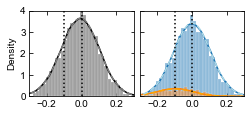

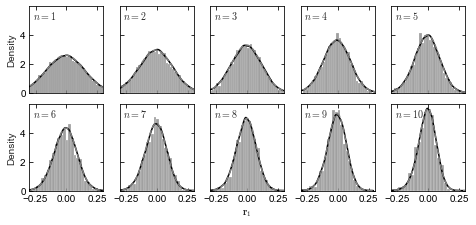

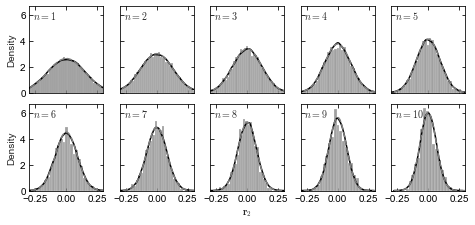

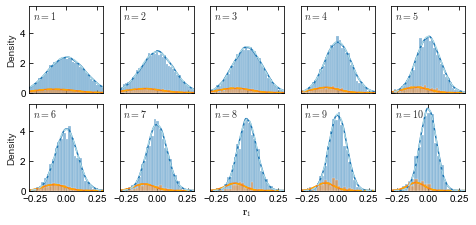

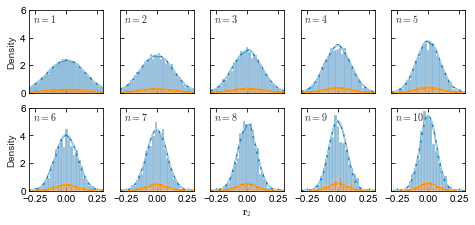

In [8]:
print('Plot Setup')
plot_setup()

if not os.path.isfile('data/Fig2_Data.pkl'):
    params = {
                'kon':0.1,
                'koff':1,
                'sigma':0.01,
                'mu':0.1,
                'num_cells':100,
                'num_abm_cells':10000,
                'vc':np.array([-0.1,0]),
                'tend': 500
            }

    print(params)

    #simulate
    abm_data, mc_data = simulator(params)
    data = {'abm':abm_data,'mc':mc_data,'params':params}

    #save data
    with open('data/Fig2_Data.pkl','wb') as f:
        pickle.dump(data,f)

print('Plotting')
with open('data/Fig2_Data.pkl','rb') as f:
    data = pickle.load(f)
make_plots(data['abm'],data['mc'],data['params'])